# Capítulo 12: Autocodificadores

In [12]:
import os
import glob
import cv2
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from keras import models, layers, optimizers
from keras.layers import Input, Dense
from keras.models import Model
from pathlib import Path
from PIL import Image

In [13]:
lista_flores = []
carpeta_imagenes = 'flowers/'
# Buscar imágenes con extensiones .jpg y .png (puedes agregar más extensiones si lo deseas)
extensiones = ['*.jpg', '*.png']
imagenes = []
tamaño_imagen = (64, 64)

In [14]:
for extension in extensiones:
    # Busca recursivamente en el directorio y subdirectorios
    lista_flores.extend(glob.glob(os.path.join(carpeta_imagenes, '**', extension), recursive=True))

print('Número de imágenes:', len(lista_flores))

Número de imágenes: 4317


In [15]:
def preprocesar(lista_imagenes):
    for imagen in lista_imagenes:
        try:        
            img = Image.open(imagen)        
            img = img.resize(tamaño_imagen)
            img_array = np.array(img)
            img_array = img_array.astype('float32') / 255.0
            imagenes.append(img_array)
        except Exception as e:
            print(f"Error al procesar la imagen {imagen}: {e}")
    return imagenes

In [16]:
imagenes_codificadas = preprocesar(lista_flores)

In [17]:
imagenes_codificadas = np.asarray(imagenes_codificadas)
imagenes_codificadas.shape

(4317, 64, 64, 3)

In [18]:
imagenes_codificadas = imagenes_codificadas.reshape((len(imagenes_codificadas), np.prod(imagenes_codificadas.shape[1:])))
print('Forma despúes de aplicar reshape:', imagenes_codificadas.shape)

Forma despúes de aplicar reshape: (4317, 12288)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imagenes_codificadas, imagenes_codificadas, test_size=0.2, random_state=13)
X_train.shape

(3453, 12288)

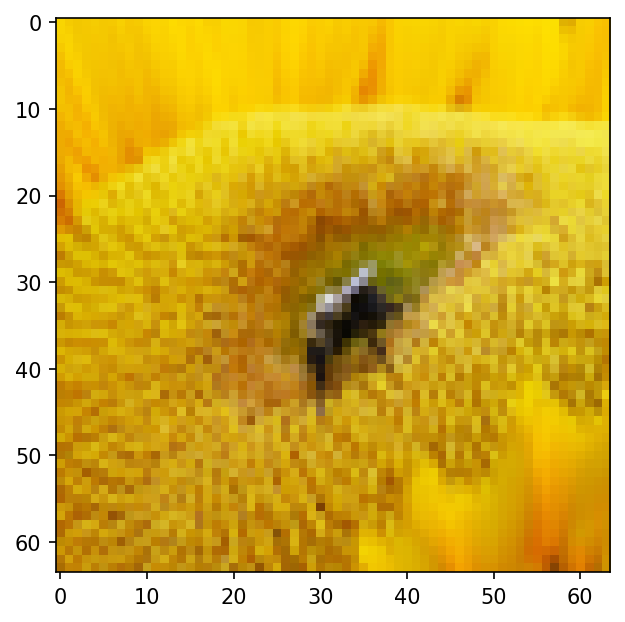

In [20]:
plt.rcParams['figure.dpi'] = 150
plt.imshow(X_train[6].reshape(64,64,3))

In [21]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model

dim_ent=12288
dim_cod=128
#dim_entrada = (64, 64, 3)

In [22]:
capa_entrada = Input(shape=(dim_ent,))
#input_layer = Input(shape=(input_dim,))
# Aplanar la entrada (64x64x3) -> (12288,)
#flat_img = Flatten()(capa_entrada)

#codificador
codificador = Dense(dim_cod * 4, activation='relu')(capa_entrada)
codificador = Dense(dim_cod * 2, activation='relu')(codificador)

# espacio latente
codificador = Dense(dim_cod, activation='relu')(codificador)

# decodificador
decodificador = Dense(dim_cod * 2, activation='relu')(codificador)
decodificador = Dense(dim_cod * 4, activation='relu')(decodificador)
decodificador = Dense(dim_ent, activation='sigmoid')(decodificador)

# Volvemos a dar forma a la imagen reconstruida (64x64x3)
#dec_img = Reshape((64, 64, 3))(decodificador)

autocodificador = Model(capa_entrada, decodificador)
autocodificador.compile(optimizer='adam', loss='binary_crossentropy')
autocodificador.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,291,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12288)               │       6,303,744 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,924,544 (49.30 MB)

 Trainable params: 12,924,544 (49.30 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Entrenar el modelo usando el X_train con forma (877, 64, 64, 3)
autocodificador.fit(X_train, X_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - loss: 0.6639 - val_loss: 0.6274
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - loss: 0.6174 - val_loss: 0.6162
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.6077 - val_loss: 0.6063
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.5957 - val_loss: 0.5919
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.5881 - val_loss: 0.5898
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - loss: 0.5789 - val_loss: 0.5822
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.5771 - val_loss: 0.5735
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - loss: 0.5694 - val_loss: 0.5749
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - loss: 0.5687 - val_loss: 0.5691
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - loss: 0.5665 - val_loss: 0.5672
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - loss: 0.5632 - val_loss: 0.5662
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


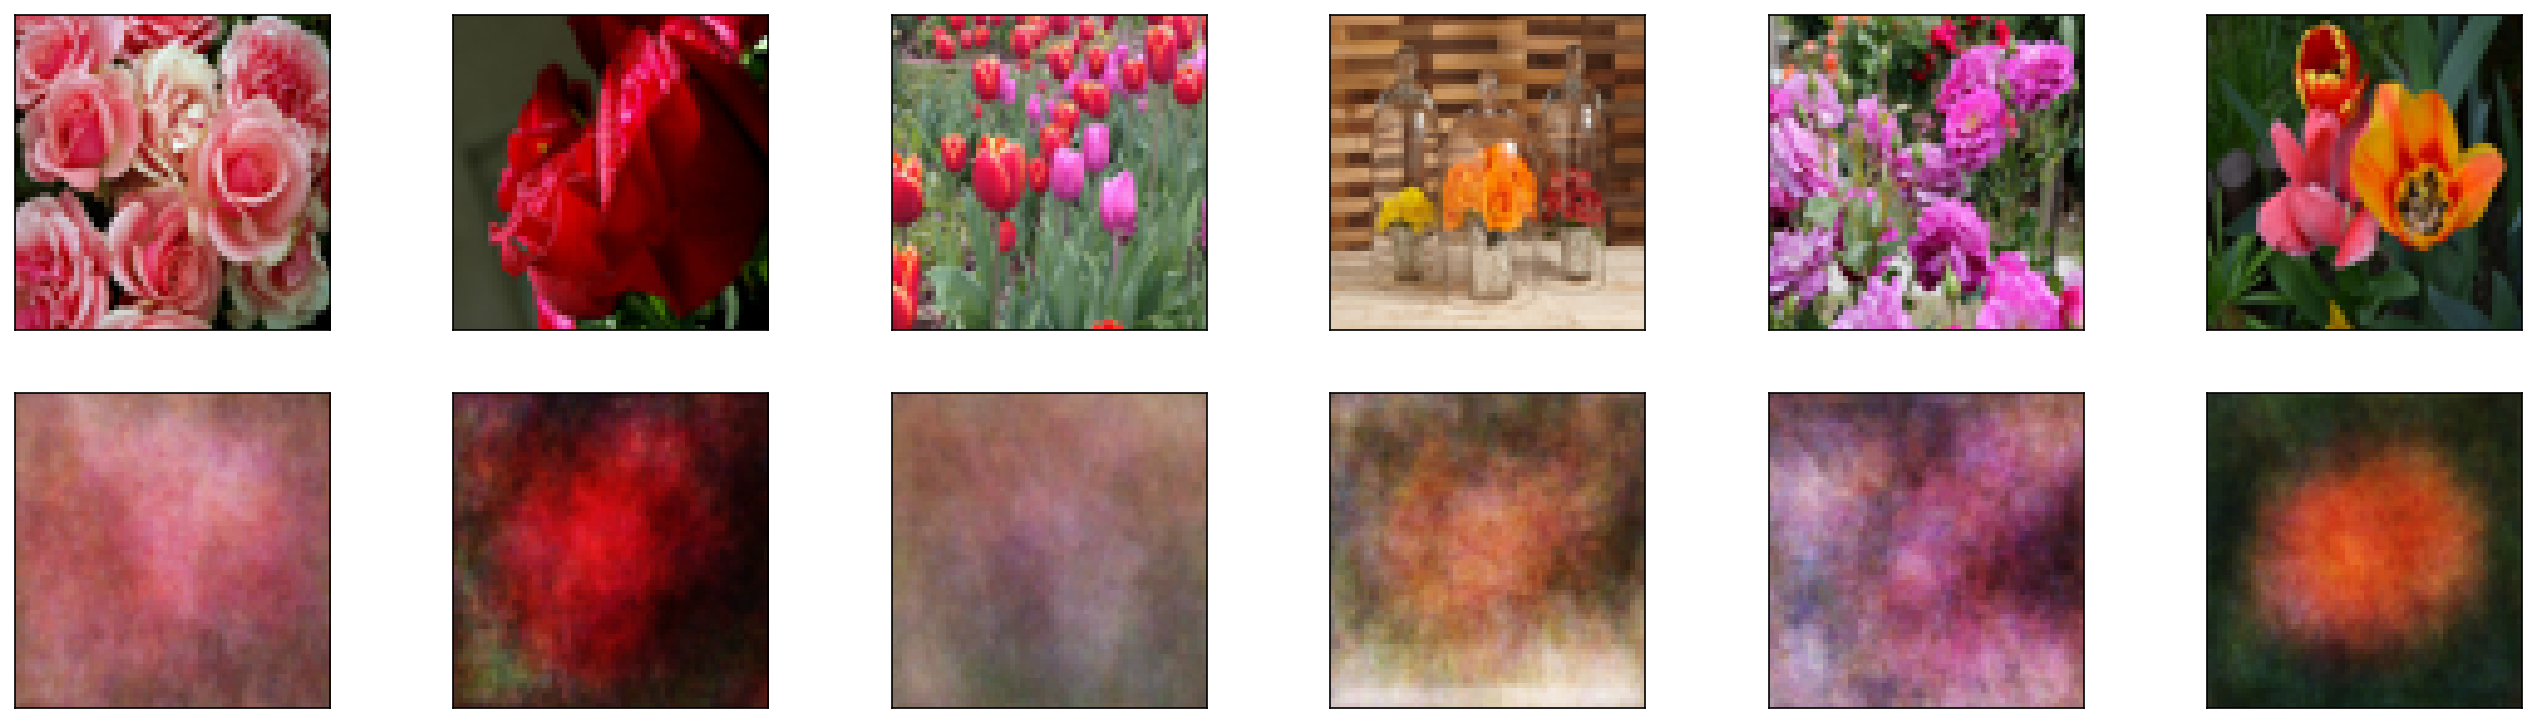

In [24]:
imgs_decodificadas = autocodificador.predict(X_test)
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 6  # how many digits we will display
plt.figure(figsize=(22, 6))
for i in range(n):
    # Mostrar imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64, 3))    #x_test
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # mostrar reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_decodificadas[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Autocodificadores con Capas Convolucionales

In [56]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

capa_entrada = Input(shape=(64, 64, 3))
#capa_entrada = Input(shape=(dim_ent,))

#Codificador
capa1 = Conv2D(32, (3, 3), activation='relu', padding='same')(capa_entrada)
capa2 = MaxPooling2D((2, 2), padding='same')(capa1)
capa3 = Conv2D(16, (3, 3), activation='relu', padding='same')(capa2)

# Capa latente: Dimensión (None, 32, 32, 16)
codificador = MaxPooling2D((1,1), padding='same')(capa3) 

# Decodificador
capa4 = Conv2D(16, (3, 3), activation='relu', padding='same')(codificador)
capa5 = UpSampling2D((2, 2))(capa4)
decodificador = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(capa5)

autocodificador2 = Model(capa_entrada, decodificador)
autocodificador2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 32, 32, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 64, 64, 3)           │             435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,275 (32.32 KB)

 Trainable params: 8,275 (32.32 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
X_train.shape

(3453, 12288)

In [60]:
autocodificador2.compile(optimizer='adam', loss='mse')
autocodificador2.fit(X_train.reshape(-1, 64, 64, 3), X_train, epochs=50, batch_size=64,
                shuffle=True, verbose=1)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0131
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0060
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0056
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0054
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0051
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0048
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0047
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0044
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0041
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0039
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0038
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0036
Epoch 13/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0035
Epoch 14/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0034
Epoch 15/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - lo

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


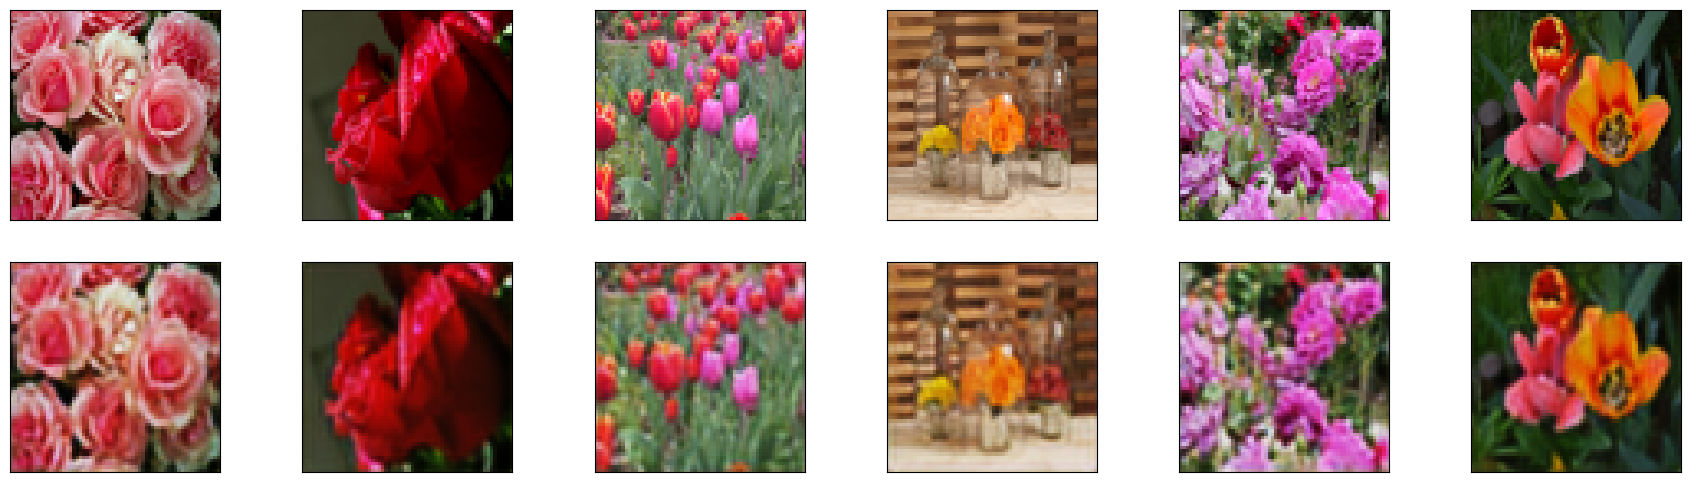

In [68]:
imgs_decod = autocodificador2.predict(X_test.reshape(-1, 64, 64, 3))

import matplotlib.pyplot as plt

n = 6  
plt.figure(figsize=(22, 6))
for i in range(n):
    # mostrar original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64, 3)) 
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # mostrar reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_decod[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Autocodificador Variacional

In [25]:
# Importar librerías
import numpy as np
from keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [26]:
# Cargar conjunto de datos MNIST
(X_train, _), (X_test, _) = mnist.load_data()

# Preprocesar datos
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = X_train.reshape((-1, 28, 28))
X_test = X_test.reshape((-1, 28, 28))

In [28]:
# Definir arquitectura del autocodificador variacional
entrada_img = Input(shape=(28, 28))
x = Reshape((784,))(entrada_img)
x = Dense(512, activation='relu')(x)
z_mean = Dense(2)(x)
z_log_var = Dense(2)(x)

# Capa de muestreo
def muestreo(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(tf.shape(z_mean), 0, 1)
    return z_mean + tf.exp(z_log_var / 2) * epsilon

z = Lambda(muestreo)([z_mean, z_log_var])

decodificador = Dense(512, activation='relu')
decodificador_salida = Dense(784, activation='sigmoid')
decodificador_oc = decodificador(z)
decodificador_salida_oc = Reshape((28, 28))(decodificador_salida(decodificador_oc))

In [29]:
import tensorflow as tf

def perdida_vae(y, y_pred, z_mean, z_log_var):
    # Reconstrucción
    perdida_reconstruccion = tf.reduce_mean(tf.square(y - y_pred))
    # Pérdida de KL
    perdida_kl = - 0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    # Pérdida total
    perdida_total = perdida_reconstruccion + perdida_kl
    return perdida_total

In [30]:
class CapaPerdidaVAE(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CapaPerdidaVAE, self).__init__(**kwargs)

    def call(self, entradas):
        y, y_pred, z_mean, z_log_var = entradas
        perdida = perdida_vae(y, y_pred, z_mean, z_log_var)
        self.add_loss(perdida)
        return tf.zeros(tf.shape(y)[0])

In [31]:
# Modelo
vae = tf.keras.Model(entrada_img, decodificador_salida_oc)
# Capa de pérdida
capa_perdida_vae = CapaPerdidaVAE()([entrada_img, decodificador_salida_oc, z_mean, z_log_var])
# Compilar modelo
vae.compile(optimizer='adam', loss='binary_crossentropy')

In [32]:
# Entrenar modelo
vae.fit(X_train, X_train, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.2877
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2081
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2006
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1965
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1942
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1923
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1910
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1893
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1884
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1866
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1857
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.1858
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1852
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1844
Epoch 15/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


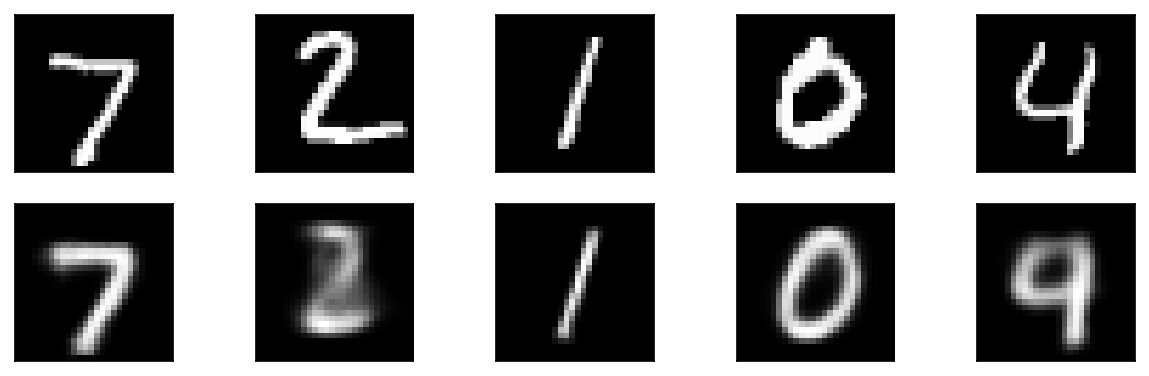

In [35]:
# Visualizar resultados
n = 5
plt.figure(figsize=(10, 3))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, n + i + 1)
    reconstruction = vae.predict(X_test[i].reshape(1, 28, 28))
    plt.imshow(reconstruction.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()